In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from gpzoo.kernels import RBF
from gpzoo.gp import SVGP2
from gpzoo.likelihoods import GaussianLikelihood

/tmp/ipykernel_3414422/3777353461.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

device(type='cuda', index=0)

In [3]:
N = 10000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))

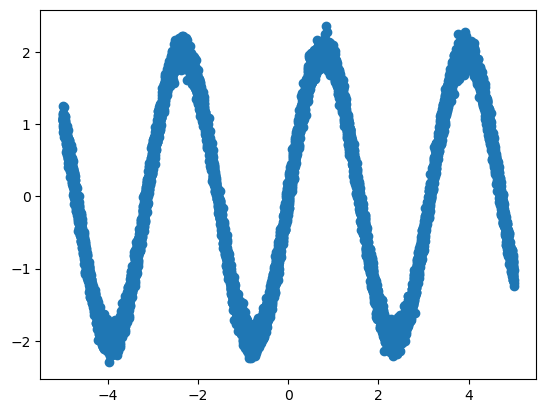

In [4]:
plt.scatter(X, y)

In [5]:
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = SVGP2(X[:, None], kernel, dim=1, jitter=1e-3)
model = GaussianLikelihood(gp)

In [120]:
model.to(device)

GaussianLikelihood(
  (gp): SVGP2(
    (kernel): RBF()
  )
)

In [7]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [8]:
def fit(model, X, y, optimizer, epochs=1000, E=20, batch_size=1000):
    losses = []
    for it in tqdm(range(epochs)):
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, idx=idx, E=E)
        ELBO = (pY.log_prob(y[idx])).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [225]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-4)

In [226]:
model.gp.jitter = 1e-3

In [264]:
losses = fit(model, X_train, y_train, optimizer, epochs=2000, E=20, batch_size=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

finished Training


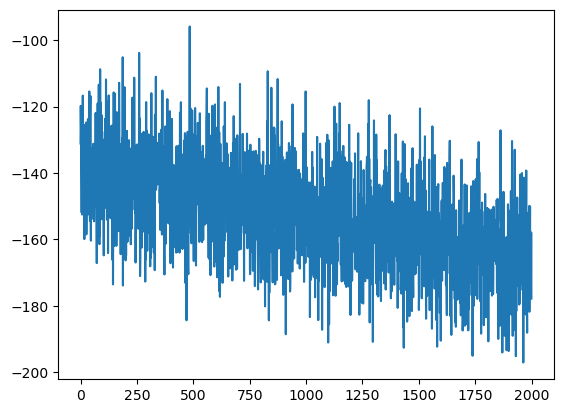

In [265]:
plt.plot(losses)

In [266]:
X_test = torch.linspace(-12, 12, 2000)
idx = torch.multinomial(torch.ones(X_train.shape[0]), num_samples=1000, replacement=False)

In [267]:
qF, _, _ = model.gp.forward_test(X_train, idx, X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()

calculating Kxx
calculating Kzx
calculating kzz
calculating cholesky
calculating W


In [268]:
mean_test.shape

torch.Size([2000])

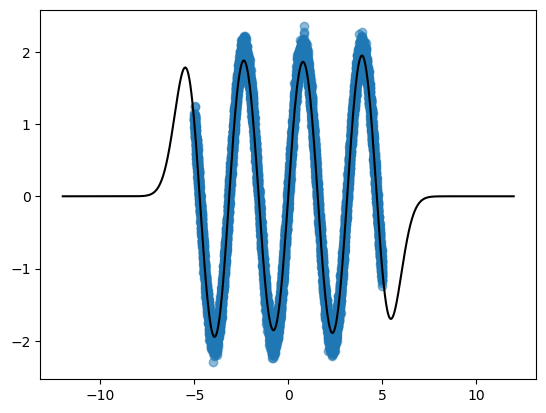

In [269]:
plt.plot(X_test, mean_test, color='black')
plt.scatter(X, y, alpha=0.5)

In [270]:
model.gp.kernel.lengthscale #= nn.Parameter(torch.tensor(1.0))

Parameter containing:
tensor(0.7524, requires_grad=True)

In [271]:
model.gp.kernel.sigma

Parameter containing:
tensor(1.0550, device='cuda:0', requires_grad=True)

In [272]:
model.noise

Parameter containing:
tensor(-1.9760, device='cuda:0', requires_grad=True)